In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer

# Importar archivo

In [2]:
data = pd.read_csv("/content/costumers (1).csv")

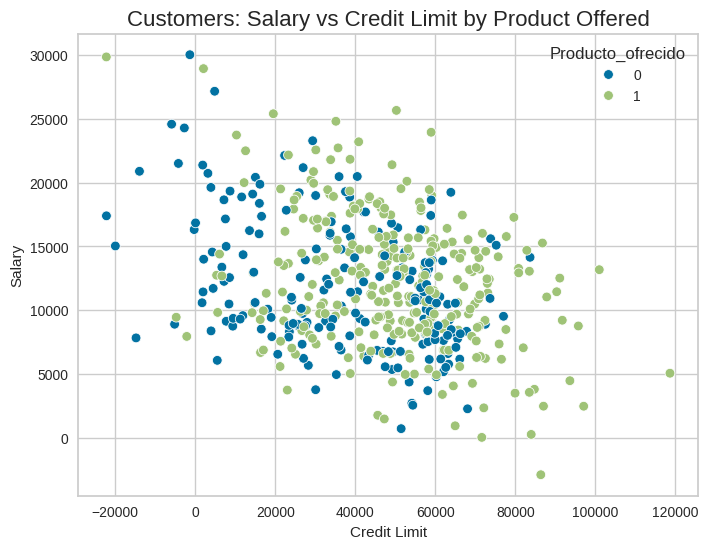

In [3]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Limite_TC', y='Salario', hue='Producto_ofrecido', data=data)
plt.title('Customers: Salary vs Credit Limit by Product Offered', fontsize=16)
plt.xlabel('Credit Limit')
plt.ylabel('Salary')
plt.show()

# 1. PCA and clusters

In [4]:
features = data.columns
X = data[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to keep 80% of variance
pca = PCA(n_components=0.8)
X_pca = pca.fit_transform(X_scaled)

print(f'Number of PCA components selected: {pca.n_components_}')
print(f'Explained variance ratio per component: {pca.explained_variance_ratio_}')


Number of PCA components selected: 3
Explained variance ratio per component: [0.36055633 0.30087965 0.16662666]


# 2. Elbow Method

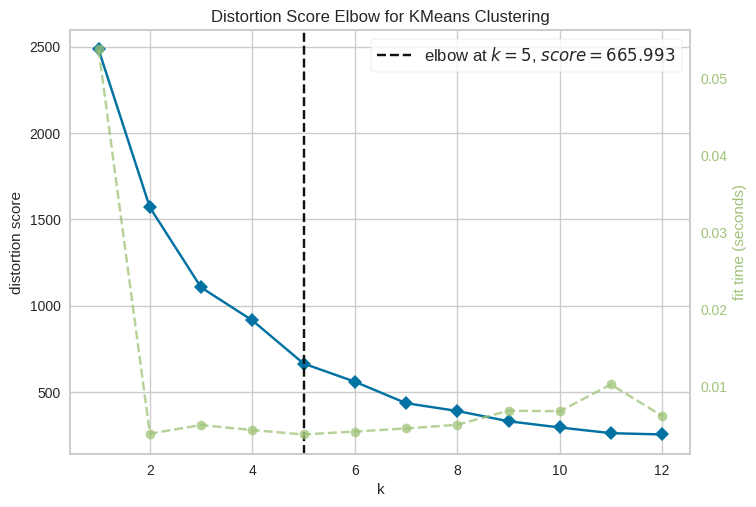

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
model = KMeans(random_state=10)
visualizer = KElbowVisualizer(model, k=(1, 13))

visualizer.fit(X_pca)
visualizer.show()

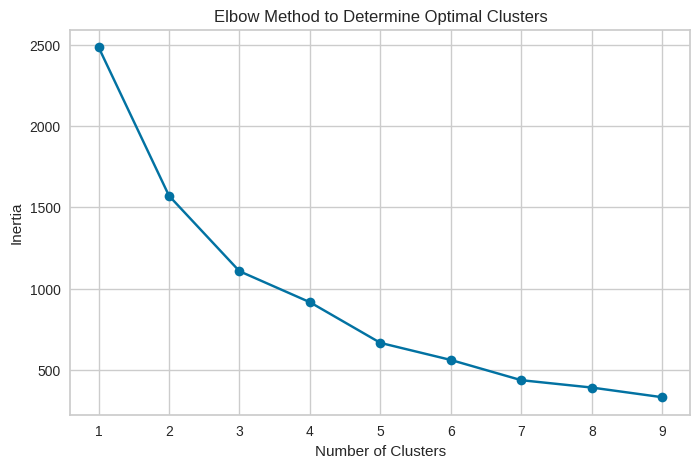

In [6]:
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()


In [7]:
optimal_clusters = 5
kmeans_model = KMeans(n_clusters=optimal_clusters, random_state=10)
clusters = kmeans_model.fit_predict(X_pca)

# Create DataFrame for visualization
plot_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'PCA3': X_pca[:, 2],
    'Cluster': clusters.astype(str)
})


In [8]:
# 3D scatter plot of clusters
fig = px.scatter_3d(plot_df, x='PCA1', y='PCA2', z='PCA3', color='Cluster',
                    title='3D Visualization of Customer Clusters', width=800)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [9]:

print(f'Silhouette Score: {silhouette_score(X_pca, clusters):.3f}')
print(f'Calinski-Harabasz Score: {calinski_harabasz_score(X_pca, clusters):.3f}')
print(f'Davies-Bouldin Score: {davies_bouldin_score(X_pca, clusters):.3f}')


Silhouette Score: 0.412
Calinski-Harabasz Score: 337.844
Davies-Bouldin Score: 0.858


In [10]:
# Add the 'Cluster' column to the original data DataFrame
data['Cluster'] = clusters

# Compute summary statistics
cluster_summary = data.groupby('Cluster')[['Salario', 'Limite_TC', 'Tiempo_cliente']].mean().reset_index()

# Ensure all cluster indices from 0 to 4 are included for counts
all_clusters = range(optimal_clusters)

# Add counts per category, reindexing to include all clusters and fill missing with 0
cluster_summary['Count_Credito_tipo_1'] = (
    data[data['Credito_tipo_1'] == 1]
    .groupby('Cluster')['Credito_tipo_1']
    .count()
    .reindex(all_clusters, fill_value=0)
    .values
)

cluster_summary['Count_Credito_tipo_2'] = (
    data[data['Credito_tipo_2'] == 1]
    .groupby('Cluster')['Credito_tipo_2']
    .count()
    .reindex(all_clusters, fill_value=0)
    .values
)

cluster_summary['Count_Product_Offered'] = (
    data[data['Producto_ofrecido'] == 1]
    .groupby('Cluster')['Producto_ofrecido']
    .count()
    .reindex(all_clusters, fill_value=0)
    .values
)

cluster_summary['Count_Product_Not_Offered'] = (
    data[data['Producto_ofrecido'] == 0]
    .groupby('Cluster')['Producto_ofrecido']
    .count()
    .reindex(all_clusters, fill_value=0)
    .values
)

cluster_summary['Total_Customers'] = data.groupby('Cluster')['Cluster'].count().values

display(cluster_summary)

,Cluster,Salario,Limite_TC,Tiempo_cliente,Count_Credito_tipo_1,Count_Credito_tipo_2,Count_Product_Offered,Count_Product_Not_Offered,Total_Customers
0,0,18144.498654,27156.705192,0.328846,89,0,61,43,104
1,1,10526.984205,56354.119545,7.101136,85,8,0,88,88
2,2,13570.489333,66443.612556,8.437778,89,3,90,0,90
3,3,10066.916837,19743.741122,0.191837,8,98,42,56,98
4,4,8527.036083,55783.382167,6.051667,34,120,108,12,120


<ipython-input-11-2020517780>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




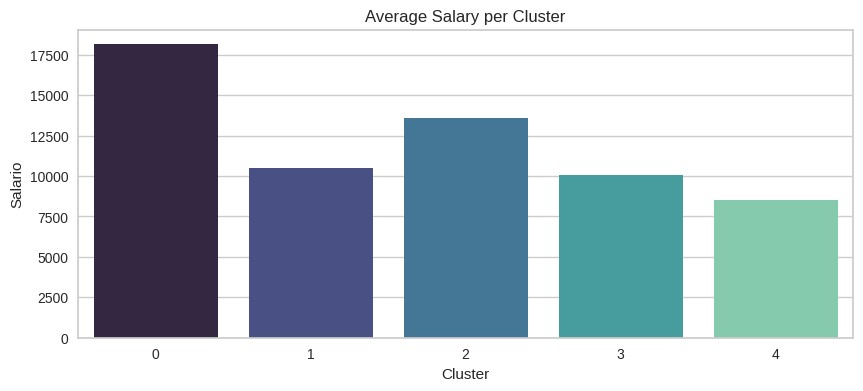

<ipython-input-11-2020517780>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




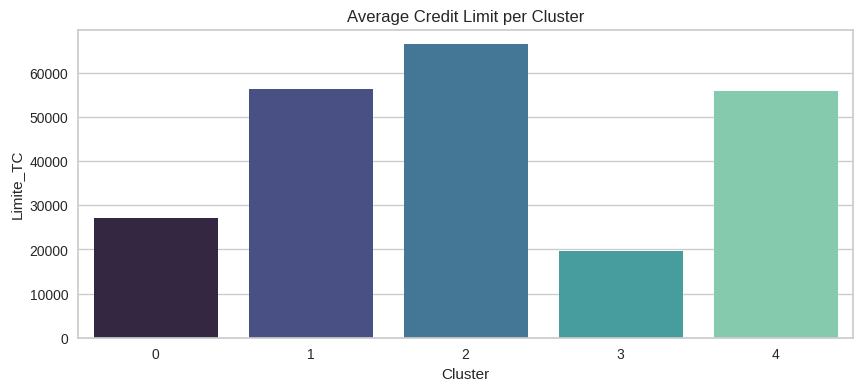

<ipython-input-11-2020517780>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




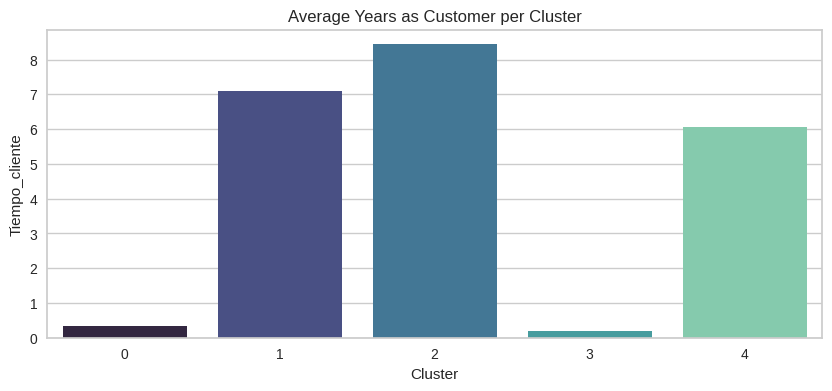

In [11]:
plt.figure(figsize=(10,4))
sns.barplot(x='Cluster', y='Salario', data=cluster_summary, palette='mako')
plt.title('Average Salary per Cluster')
plt.show()

# Plot average Credit Limit per cluster
plt.figure(figsize=(10,4))
sns.barplot(x='Cluster', y='Limite_TC', data=cluster_summary, palette='mako')
plt.title('Average Credit Limit per Cluster')
plt.show()

# Plot average Time as Customer per cluster
plt.figure(figsize=(10,4))
sns.barplot(x='Cluster', y='Tiempo_cliente', data=cluster_summary, palette='mako')
plt.title('Average Years as Customer per Cluster')
plt.show()


#Cluster Results Analysis
##Cluster 0 – New Clients with High Income and Low Credit Limits
This group consists of 104 clients. They have the highest average salary of all the groups ≈$18,144 but interestingly, they have a relatively low credit card limit ≈$27,157. Furthermore, they have very short customer tenure (≈0.33 years), indicating that they are new to the institution. The majority have Type 1 Credit (89 people), and 43 have not been offered a product, while 61 have received one. This group represents newly acquired clients with good incomes but still low credit exposure.

##Cluster 1 – Loyal customers with low income and high credit, but no products offered
This group includes 88 customers with a low average salary (≈$10,527), but a high credit limit (≈$56,354), and considerable tenure (≈7.1 years). Virtually all have Type 1 Credit, but what is interesting is that none have any products offered (0), which could be a missed opportunity for the company. This suggests that they are loyal and trustworthy customers, but that they are not being incentivized with new products.

##Cluster 2 – Long-standing customers with medium income and high credit limits
This group includes 90 customers with a medium-high income (≈$13,570), a very high credit limit (≈$66,444), and a long relationship with the company (≈8.4 years). Most have Type 1 Credit, and almost all have received products offered (90 out of 90). This is an ideal group for loyalty and promotion, as they have purchasing power, company trust, and customer experience.

##Cluster 3 – New, Low-Income Customers with Type 2 Credit
With 98 customers, this group has the lowest salary (≈$10,066) and also the lowest credit limit (≈$19,744), with almost no tenure (≈0.19 years). Unlike other groups, the majority have Type 2 Credit (98 people), which makes them unique. Furthermore, many do not have any products offered (56). They represent a segment of new, low-income customers with a higher risk profile (due to the type of credit), who may require monitoring or financial education.

##Cluster 4 – Long-standing, Low-Income Customers with Good Product Responsiveness
This is the largest group, with 120 customers. They have the lowest average salary (≈$8,527), but a surprisingly high credit limit (≈$55,783). Their tenure is medium-high (≈6 years). The majority have Type 2 Credit (120 people), and 108 of them did accept products offered. This group appears to be very receptive to offers despite their low income, making them an ideal segment for targeted marketing and loyalty programs.

General Conclusion of the Results
The five clusters show very distinct customer profiles, validating the usefulness of the clustering model. High-value groups (such as Cluster 2), groups with growth potential (such as Clusters 0 and 4), and others where offering strategies could be improved (such as Cluster 1) are clearly identified. This segmentation allows the company to design specific campaigns for each type of customer, improving both retention and profitability.

In [12]:
joblib.dump(kmeans_model, 'kmeans_model.pkl')
joblib.dump(pca, 'pca_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Prepare New Customer Data


In [13]:
new_data = pd.read_csv("/content/new_costumer.csv")

In [14]:
import joblib

# Load the saved scaler, PCA, and KMeans model
scaler = joblib.load("modelo_scaler.pkl")
pca = joblib.load("modelo_pca.pkl")
kmeans_model = joblib.load("modelo_kmeans.pkl")

In [15]:
# Drop the column that wasn't used in training
new_data_cleaned = new_data.drop(columns=['Tipo_de_cliente'])


In [16]:
# Scale and apply PCA
new_data_scaled = scaler.transform(new_data_cleaned)
new_data_pca = pca.transform(new_data_scaled)

In [17]:
new_clusters = kmeans_model.predict(new_data_pca)

In [18]:
# Create DataFrame for original data
original_df = pd.DataFrame(pca.transform(scaler.transform(data.drop('Cluster', axis=1))),
                           columns=['PCA1', 'PCA2', 'PCA3'])
original_df['Cluster'] = data['Cluster']
original_df['Dataset'] = 'Original'

# Create DataFrame for new data
new_df = pd.DataFrame(new_data_pca, columns=['PCA1', 'PCA2', 'PCA3'])
new_df['Cluster'] = new_clusters
new_df['Dataset'] = 'New'

# Combine both
combined_df = pd.concat([original_df, new_df], ignore_index=True)

In [19]:
import plotly.express as px

fig = px.scatter_3d(
    combined_df,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='Cluster',
    symbol='Dataset',  # different shape for new customers
    title='Customer Clusters with New Data',
    width=900,
    height=600
)
fig.update_layout(
    legend_title='Customer Cluster and Dataset',
    legend=dict(x=0, y=1),
    scene=dict(
        xaxis_title='PCA1',
        yaxis_title='PCA2',
        zaxis_title='PCA3'
    )
)
fig.show()


<ipython-input-20-2341658894>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




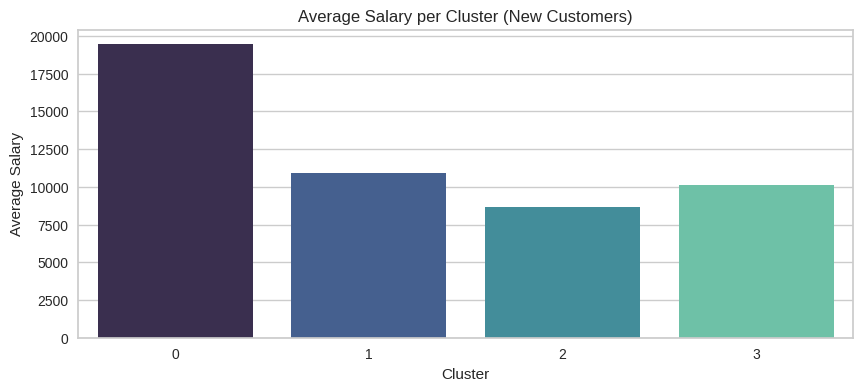

<ipython-input-20-2341658894>:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




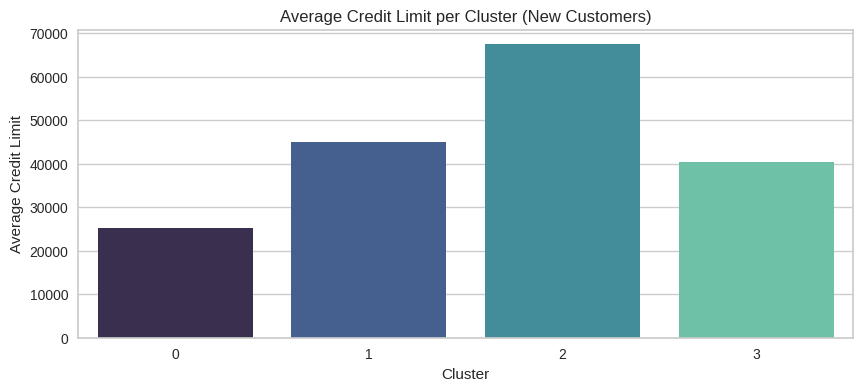

<ipython-input-20-2341658894>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




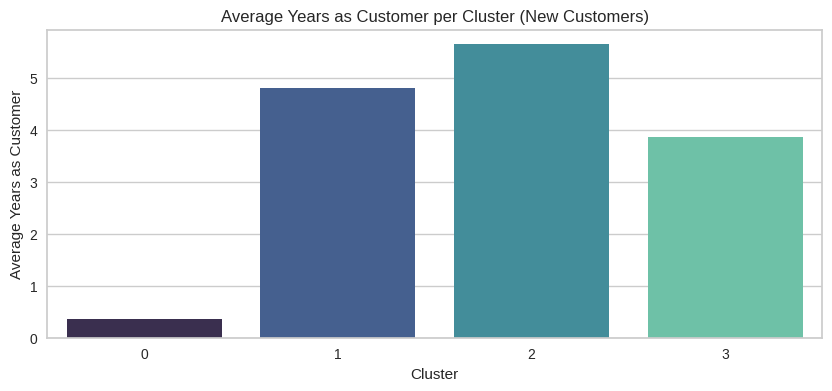

In [20]:
# Add the predicted clusters to the cleaned new customer DataFrame
new_data_cleaned['Cluster'] = new_clusters

# Calculate summary statistics for the new customers only
new_customer_summary = new_data_cleaned.groupby('Cluster')[['Salario', 'Limite_TC', 'Tiempo_cliente']].mean().reset_index()

# Plot average Salary per cluster
plt.figure(figsize=(10, 4))
sns.barplot(x='Cluster', y='Salario', data=new_customer_summary, palette='mako')
plt.title('Average Salary per Cluster (New Customers)')
plt.xlabel('Cluster')
plt.ylabel('Average Salary')
plt.show()

# Plot average Credit Limit per cluster
plt.figure(figsize=(10, 4))
sns.barplot(x='Cluster', y='Limite_TC', data=new_customer_summary, palette='mako')
plt.title('Average Credit Limit per Cluster (New Customers)')
plt.xlabel('Cluster')
plt.ylabel('Average Credit Limit')
plt.show()

# Plot average Time as Customer per cluster
plt.figure(figsize=(10, 4))
sns.barplot(x='Cluster', y='Tiempo_cliente', data=new_customer_summary, palette='mako')
plt.title('Average Years as Customer per Cluster (New Customers)')
plt.xlabel('Cluster')
plt.ylabel('Average Years as Customer')
plt.show()

In [21]:
# Define range of all clusters
all_clusters_new = range(optimal_clusters)

# Compute base summary with means, then reindex to include all clusters
new_cluster_summary = (
    new_data_cleaned
    .groupby('Cluster')[['Salario', 'Limite_TC', 'Tiempo_cliente']]
    .mean()
    .reindex(all_clusters_new)  # Ensures all clusters are included
    .reset_index()
)

# Add counts per category
new_cluster_summary['Count_Credito_tipo_1'] = (
    new_data_cleaned[new_data_cleaned['Credito_tipo_1'] == 1]
    .groupby('Cluster')['Credito_tipo_1']
    .count()
    .reindex(all_clusters_new, fill_value=0)
    .values
)

new_cluster_summary['Count_Credito_tipo_2'] = (
    new_data_cleaned[new_data_cleaned['Credito_tipo_2'] == 1]
    .groupby('Cluster')['Credito_tipo_2']
    .count()
    .reindex(all_clusters_new, fill_value=0)
    .values
)

new_cluster_summary['Count_Product_Offered'] = (
    new_data_cleaned[new_data_cleaned['Producto_ofrecido'] == 1]
    .groupby('Cluster')['Producto_ofrecido']
    .count()
    .reindex(all_clusters_new, fill_value=0)
    .values
)

new_cluster_summary['Count_Product_Not_Offered'] = (
    new_data_cleaned[new_data_cleaned['Producto_ofrecido'] == 0]
    .groupby('Cluster')['Producto_ofrecido']
    .count()
    .reindex(all_clusters_new, fill_value=0)
    .values
)

new_cluster_summary['Total_Customers'] = (
    new_data_cleaned
    .groupby('Cluster')['Cluster']
    .count()
    .reindex(all_clusters_new, fill_value=0)
    .values
)

# Replace missing means (e.g., NaN) with 0 or any other value you'd like
new_cluster_summary.fillna(0, inplace=True)

# Display the summary
display(new_cluster_summary)


,Cluster,Salario,Limite_TC,Tiempo_cliente,Count_Credito_tipo_1,Count_Credito_tipo_2,Count_Product_Offered,Count_Product_Not_Offered,Total_Customers
0,0,19431.318824,25148.658824,0.364706,15,0,12,5,17
1,1,10922.978000,45003.690000,4.800000,4,0,0,5,5
2,2,8686.564000,67419.670000,5.640000,5,2,5,0,5
3,3,10140.243043,40499.543043,3.860870,2,23,18,5,23
4,4,0.000000,0.000000,0.000000,0,0,0,0,0


The results show that the majority of new clients (23 people) were assigned to Group 3, characterized by middle-income individuals with a medium-high credit limit and an average tenure of between 3 and 6 years as clients. This was followed by Group 0 with 17 new clients, composed of high-income individuals with low credit limits and who were new clients. Group 1 then received five clients, defined as middle-income individuals with low credit limits and more than 7 years of tenure. Group 2 also received five clients, consisting of high-income individuals with high credit limits and who were relatively new. Finally, Group 4, composed of low-income individuals with high credit limits and more than 6 years as clients, did not receive any new clients. This suggests that new clients tend to have medium-high income profiles and short tenure, or are integrated into groups with intermediate stability.